---
title: "[Conditional Inference for Financial Order Routing Using Energy-Based Models](../index.qmd)"
title-block-banner: true
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brumoema/ising-conditional-routing/blob/main/experiments/real_data.ipynb)

# Conditional Routing Experiment - Live Historical Data

**NOTE**: This notebook is configured to run on **fresh historical data** using a rolling window. The results will differ from the fixed dataset used in the article.



## Logic and Workflow:
- **Data Processing**: Synchronizes raw trade data into time buckets, labeling only the single best venue as 'favorable' (argmax).
- **Fair Information Sharing**: Baselines update only on the Selected Venue, while THRML performs joint updates on multiple nodes (context + routed).
- **Conditional Context**: At each step, the agent observes the outcome of a 'context venue' before deciding where to route the order.
- **THRML Advantage**: Leverages learned Ising correlations between exchanges to perform conditional inference (via clamped sampling) to identify the venue with the highest probability of success given the context.

## Key Hyperparameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| `n_venues` | 3 | Number of trading venues |
| `n_steps` | 10,000 | Steps per experiment run |
| `n_seeds` | 200 | Independent runs for statistical significance |
| `discount_factor` | 0.995 | Forgetting factor for non-stationary adaptation |
| `learning_rate` | 0.05 | THRML learning rate |
| `coupling_decay` | 0.995 | Decay factor for edge weights (regularization) |
| `steps_per_sample` | 4 | Gibbs sampling thinning parameter |
| `propagation_damping` | 0.3 | Mean-field signal propagation factor |

## Agents Compared
- **Contextual ε-Greedy**: Maintains context-specific success/count statistics with ε=0.1 exploration
- **Contextual Thompson Sampling**: Uses Beta-distributed posteriors conditioned on context
- **THRML**: Leverages an Ising model to capture correlations between venues and performs probabilistic inference using Gibbs sampling

## Context Modes
- **Fixed Context**: Always observe Venue 0's outcome as context
- **Random Context**: Randomly select which venue provides context each step


# Conditional Routing Experiment - Historical Data

## 1. Setup & Infrastructure

In [1]:
# Install necessary libraries for the experiment in the Colab environment
%pip install -q ccxt pandas thrml>=0.1.3 matplotlib

In [2]:
# --- STANDARD IMPORTS ---
import os
import sys
import time
from typing import NamedTuple, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, lax, vmap, jit
from thrml import SpinNode, Block, SamplingSchedule, sample_states
from thrml.models import IsingEBM, IsingSamplingProgram, hinton_init
import ccxt

print("--- HISTORICAL DATA EXPERIMENT ---")
print("This notebook fetches historical trade data for reproducibility.")
print("Ready to go!")

--- HISTORICAL DATA EXPERIMENT ---
This notebook fetches historical trade data for reproducibility.
Ready to go!


## 2. Configuration

In [3]:
# Configuration settings for the experiments and agents
class ExperimentConfig(NamedTuple):
    n_venues: int = 3  # Number of trading venues participating in the simulation
    n_steps: int = 10000  # Total simulation steps per independent run
    n_seeds: int = 200
    window_size: int = 200  # Memory depth for incremental covariance tracking
    beta: float = 1.0
    n_warmup: int = 50
    n_samples: int = 100
    steps_per_sample: int = 4
    discount_factor: float = 0.995  # Exponential decay factor for adapting to non-stationary shifts
    learning_rate: float = 0.05  # Step size for bias and edge weight updates
    coupling_decay: float = 0.995
    propagation_damping: float = 0.3
    context_mode: str = "fixed"
    damp_coupling: bool = True

In [4]:
class AgentState_CEG(NamedTuple):
    successes: jnp.ndarray
    counts: jnp.ndarray

class AgentState_CTS(NamedTuple):
    alphas: jnp.ndarray
    betas: jnp.ndarray

class AgentState_THRML(NamedTuple):
    biases: jnp.ndarray
    weights: jnp.ndarray
    history_buffer: jnp.ndarray
    history_ptr: jnp.ndarray
    full_history_count: jnp.ndarray
    cov_sum: jnp.ndarray
    pair_counts: jnp.ndarray

In [5]:
def thrml_init(n_venues, window_size=200):
    """
    Standardized initialization for THRML Agent State.
    Ensures memory depth is consistent across experiments.
    """
    return AgentState_THRML(
        biases=jnp.zeros(n_venues),
        weights=jnp.zeros((n_venues * (n_venues - 1)) // 2),
        history_buffer=jnp.zeros((window_size, n_venues)),
        history_ptr=jnp.array(0, dtype=jnp.int32),
        full_history_count=jnp.array(0, dtype=jnp.int32),
        cov_sum=jnp.zeros((n_venues, n_venues)),
        pair_counts=jnp.zeros((n_venues, n_venues))
    )

def thrml_update(state, outcomes, obs_mask, model_node_moms, model_edge_moms, 
                 discount_factor, beta, learning_rate, 
                 propagation_damping=0.3, coupling_decay=1.0, damp_coupling=True):
    """
    Perform the learning step using the THRML Ising model.
    Uses contrastive divergence principles (Data Moments vs Model Moments).
    """
    n_venues = state.biases.shape[0]
    triu_idx = jnp.triu_indices(n_venues, 1)
    
    # 1. Update Node Biases (h)
    J = jnp.zeros((n_venues, n_venues)).at[triu_idx].set(state.weights)
    J = J + J.T
    influence = propagation_damping * learning_rate * beta * (J @ (outcomes * obs_mask)) * (1.0 - obs_mask)
    new_biases = (state.biases * discount_factor) + (learning_rate * beta * (outcomes * obs_mask - model_node_moms * obs_mask)) + influence
    
    # 2. Update Empirical Covariance (XX^T)
    old_obs = state.history_buffer[state.history_ptr]
    old_present = (old_obs != 0).astype(jnp.float32)
    
    new_obs = outcomes * obs_mask
    new_present = obs_mask
    
    new_cov_sum = state.cov_sum - jnp.outer(old_obs, old_obs) + jnp.outer(new_obs, new_obs)
    new_pair_counts = state.pair_counts - jnp.outer(old_present, old_present) + jnp.outer(new_present, new_present)
    
    # 3. Handle Cyclic Buffer
    new_buffer = state.history_buffer.at[state.history_ptr].set(new_obs)
    new_ptr = (state.history_ptr + 1) % state.history_buffer.shape[0]
    new_count = jnp.minimum(state.full_history_count + 1, state.history_buffer.shape[0])
    
    # 4. Update Edge Weights (J)
    emp_cov = new_cov_sum / jnp.maximum(new_pair_counts, 1.0)
    emp = emp_cov[triu_idx]
    
    pairs_observed = new_pair_counts[triu_idx] > 0
    innovation = beta * learning_rate * (emp - model_edge_moms)
    innovation = jnp.where(damp_coupling, innovation, 0.0)
    new_weights = (state.weights + jnp.where(pairs_observed, innovation, 0.0)) * discount_factor * coupling_decay
    
    return AgentState_THRML(new_biases, new_weights, new_buffer, new_ptr, new_count, new_cov_sum, new_pair_counts)

In [6]:
def build_thrml_infra(n_venues, config):
    """Pre-calculate static graph paths to avoid recompilation overhead in JAX loop."""
    nodes = [SpinNode() for _ in range(n_venues)]
    edges = [(nodes[i], nodes[j]) for i in range(n_venues) for j in range(i+1, n_venues)]
    schedule = SamplingSchedule(
        n_warmup=config.n_warmup, 
        n_samples=config.n_samples, 
        steps_per_sample=config.steps_per_sample
    )
    infra_list = []
    for v_idx in range(n_venues):
        infra_list.append({
            'clamped': Block([nodes[v_idx]]),
            'free': [Block([nodes[i]]) for i in range(n_venues) if i != v_idx]
        })
    
    # NEW: Add static logic for unclamped joint sampling
    # Note: Use serial schedule (one node per block) for fully connected graph
    serial_blocks = [Block([n]) for n in nodes]
    joint_infra = {'free': serial_blocks, 'clamped': []}
    
    return {
        'nodes': nodes, 'edges': edges, 'sched': schedule, 
        'list': infra_list, 'joint': joint_infra, 'full_block': [Block(nodes)]
    }

In [7]:
# Context helper functions to manage venue outcomes
def get_context_index(context_venue: int, context_outcome: jnp.ndarray) -> int:
    """
    Convert (venue, outcome) to a single context index.
    Context index = context_venue * 2 + (1 if outcome > 0 else 0)
    """
    outcome_bit = jnp.where(context_outcome > 0, 1, 0)
    return context_venue * 2 + outcome_bit

# Baseline agent initialization functions
def ceg_init(n_venues: int) -> AgentState_CEG:
    """Initialize Contextual Epsilon-Greedy agent state."""
    n_contexts = n_venues * 2  # Each venue × 2 outcomes
    return AgentState_CEG(
        successes=jnp.zeros((n_contexts, n_venues)),
        counts=jnp.zeros((n_contexts, n_venues))
    )

def cts_init(n_venues: int, prior_alpha: float=1.0, prior_beta: float=1.0) -> AgentState_CTS:
    """Initialize Contextual Thompson Sampling agent state."""
    n_contexts = n_venues * 2
    return AgentState_CTS(
        alphas=jnp.ones((n_contexts, n_venues)) * prior_alpha,
        betas=jnp.ones((n_contexts, n_venues)) * prior_beta
    )

def ceg_select(state, key, cidx, routing_mask, epsilon=0.1):
    """Choose venue using tabular E-Greedy given context."""
    n = state.counts.shape[1]
    means = jnp.where(state.counts[cidx] > 0, state.successes[cidx] / state.counts[cidx], 0.5)
    k_e, k_r = random.split(key)
    act = jnp.where(random.uniform(k_e) < epsilon, 
                    random.categorical(k_r, jnp.zeros(n) + routing_mask), 
                    jnp.argmax(means + routing_mask))
    return act

def cts_select(state, key, cidx, routing_mask):
    """Choose venue using Bayesian sampling given context."""
    samples = random.beta(key, state.alphas[cidx], state.betas[cidx])
    return jnp.argmax(samples + routing_mask)

In [8]:
# =============================================================================
# ROLLING WINDOW CONFIGURATION - ALWAYS FETCHES LATEST 10K STEPS
# =============================================================================
# This experiment uses a ROLLING 10,000 second window that automatically
# fetches the most recent available data. This ensures:
#   1. Data is always fresh and reflects current market conditions
#   2. Results are based on up-to-date exchange behavior
#   3. Each run independently validates the experiment on new data
#
# The window ends 5 minutes ago (to ensure trade data has propagated)
# and spans exactly 10,000 seconds (~2.78 hours) backward from there.
# =============================================================================

import time
from datetime import datetime, timezone

# Configuration
EXPECTED_STEPS = 10000  # Exactly 10k steps (10k seconds)
BUFFER_SECONDS = 300    # 5-minute buffer to ensure data availability

# Calculate rolling window: ends 5 min ago, spans 10k seconds back
current_time_ms = int(time.time() * 1000)
HIST_END_MS = current_time_ms - (BUFFER_SECONDS * 1000)  # 5 min ago
HIST_START_MS = HIST_END_MS - (EXPECTED_STEPS * 1000)    # 10k seconds before that

# Display the window
start_dt = datetime.fromtimestamp(HIST_START_MS / 1000, tz=timezone.utc)
end_dt = datetime.fromtimestamp(HIST_END_MS / 1000, tz=timezone.utc)

print("=" * 65)
print("ROLLING WINDOW EXPERIMENT - LATEST 10,000 STEPS")
print("=" * 65)
print(f"Window Start: {start_dt.strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Window End:   {end_dt.strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Duration:     {EXPECTED_STEPS:,} seconds ({EXPECTED_STEPS:,} steps)")
print(f"Data Age:     ~{BUFFER_SECONDS // 60} minutes old (buffer for propagation)")
print("=" * 65)
print("Note: Each run fetches fresh data, so results may vary slightly")
print("between runs due to different market conditions.")

ROLLING WINDOW EXPERIMENT - LATEST 10,000 STEPS
Window Start: 2026-02-02 13:12:24 UTC
Window End:   2026-02-02 15:59:04 UTC
Duration:     10,000 seconds (10,000 steps)
Data Age:     ~5 minutes old (buffer for propagation)
Note: Each run fetches fresh data, so results may vary slightly
between runs due to different market conditions.


In [9]:
SYMBOL = 'BTC/USD'; EXCHANGES = ['coinbaseexchange', 'kraken', 'bitstamp']; TIME_BUCKET_MS = 1000
TARGET_BUCKETS = 10000  # Rolling window: exactly 10,000 steps

In [10]:
def sync_trades_hist(exchange_name: str, start_ms: int, end_ms: int) -> pd.DataFrame:
    """
    Fetch historical trades from exchange for a specific time window.
    """
    exchange = getattr(ccxt, exchange_name)({'enableRateLimit': True})
    MAX_ITERATIONS = 500
    
    def get_trade_timestamp(trade):
        if 'timestamp' in trade and trade['timestamp'] is not None:
            return trade['timestamp']
        if 'datetime' in trade and trade['datetime'] is not None:
            from datetime import datetime
            dt = datetime.fromisoformat(trade['datetime'].replace('Z', '+00:00'))
            return int(dt.timestamp() * 1000)
        if 'info' in trade:
            info = trade['info']
            if 'date' in info: return int(info['date']) * 1000
            if 'timestamp' in info: return int(info['timestamp'])
        raise KeyError(f"Could not extract timestamp")
    
    try:
        exchange.load_markets()
        symbol = SYMBOL if SYMBOL in exchange.markets else "BTC/USDT"
        all_trades = []; seen_ids = set(); iterations = 0
        last_batch_id = None
        
        if exchange_name == 'kraken':
            since = start_ms
            while iterations < MAX_ITERATIONS:
                iterations += 1
                # Kraken's 'since' parameter expects milliseconds in CCXT
                trades = exchange.fetch_trades(symbol, since=since, limit=1000)
                if not trades or trades[0].get('id') == last_batch_id: break
                last_batch_id = trades[0].get('id')
                
                for t in trades:
                    ts = get_trade_timestamp(t)
                    tid = str(t.get('id', ts))
                    if start_ms <= ts <= end_ms and tid not in seen_ids:
                        seen_ids.add(tid)
                        all_trades.append({'timestamp': ts, 'price': float(t['price']), 'id': tid})
                
                if not trades: break
                last_ts = get_trade_timestamp(trades[-1])
                if last_ts >= end_ms: break
                
                try:
                    # Kraken returns 'last' id in nanoseconds, but ccxt expects ms for 'since'
                    raw = exchange.last_json_response
                    last_id_ns = int(raw['result'].get('last', str(last_ts) + '000000'))
                    since = last_id_ns // 1000000  # Convert ns to ms
                except:
                    since = last_ts + 1000 # Fallback 
                
                time.sleep(exchange.rateLimit / 1000)
                
        elif exchange_name == 'bitstamp':
            since = start_ms
            while iterations < MAX_ITERATIONS:
                iterations += 1
                # For Bitstamp, we request 'day' to get access to the 24h buffer
                trades = exchange.fetch_trades(symbol, limit=1000, since=since, params={'time': 'day'})
                
                if not trades: break
                # Check for duplicates (if API ignores 'since' and returns latest trades repeatedly)
                if trades[0].get('id') == last_batch_id: 
                    break
                last_batch_id = trades[0].get('id')
                
                for t in trades:
                    ts = get_trade_timestamp(t)
                    tid = str(t.get('id', ts))
                    if start_ms <= ts <= end_ms and tid not in seen_ids:
                        seen_ids.add(tid)
                        all_trades.append({'timestamp': ts, 'price': float(t['price']), 'id': tid})
                
                last_ts = get_trade_timestamp(trades[-1])
                if last_ts >= end_ms: break
                
                # Update since for next batch (if supported)
                since = last_ts + 1
                time.sleep(exchange.rateLimit / 1000)

        elif exchange_name == 'coinbaseexchange':
            cursor = None
            while iterations < MAX_ITERATIONS:
                iterations += 1
                params = {'limit': 1000}
                if cursor: params['after'] = cursor
                
                trades = exchange.fetch_trades(symbol, limit=1000, params=params)
                if not trades or (len(trades) > 0 and trades[0].get('id') == last_batch_id):
                    break
                last_batch_id = trades[0].get('id')
                
                if iterations == 1:
                    print(f"   [DEBUG] coinbase: Batch 1 covers {get_trade_timestamp(trades[-1])} to {get_trade_timestamp(trades[0])}")

                for t in trades:
                    ts = get_trade_timestamp(t)
                    tid = str(t.get('id', ts))
                    if start_ms <= ts <= end_ms and tid not in seen_ids:
                        seen_ids.add(tid)
                        all_trades.append({'timestamp': ts, 'price': float(t['price']), 'id': tid})
                
                oldest_ts = get_trade_timestamp(trades[-1])
                # Try to get cursor from headers first (more reliable)
                header_cursor = None
                if hasattr(exchange, 'last_response_headers') and exchange.last_response_headers:
                     header_cursor = (exchange.last_response_headers.get('cb-after') or 
                                      exchange.last_response_headers.get('CB-AFTER'))
                cursor = header_cursor or trades[-1].get('id')
                
                if oldest_ts < start_ms: break
                time.sleep(exchange.rateLimit / 1000)
        
        else:
            since = start_ms
            while iterations < MAX_ITERATIONS:
                iterations += 1
                trades = exchange.fetch_trades(symbol, since=since, limit=1000)
                if not trades or trades[0].get('id') == last_batch_id: break
                last_batch_id = trades[0].get('id')
                for t in trades:
                    ts = get_trade_timestamp(t)
                    tid = str(t.get('id', ts))
                    if start_ms <= ts <= end_ms and tid not in seen_ids:
                        seen_ids.add(tid)
                        all_trades.append({'timestamp': ts, 'price': float(t['price']), 'id': tid})
                last_ts = get_trade_timestamp(trades[-1])
                if last_ts >= end_ms: break
                since = last_ts + 1
                time.sleep(exchange.rateLimit / 1000)
        
        print(f"   + {exchange_name:<10}: Fetched {len(all_trades)} trades ({iterations} API calls).")
        if not all_trades: return pd.DataFrame(columns=['timestamp', 'price', 'id'])
        return pd.DataFrame(all_trades).drop_duplicates(subset=['id']).sort_values('timestamp')
        
    except Exception as e:
        print(f"   [ERROR] {exchange_name}: {e}")
        return pd.DataFrame(columns=['timestamp', 'price', 'id'])


In [ ]:
def process_market_data(dfs: Dict[str, pd.DataFrame], start_ms: int, end_ms: int):
    """
    Process raw trade data into time buckets and calculate favorable outcomes.
    Uses the specified historical time window.
    
    IMPORTANT: Some exchanges only provide recent historical data (up to 24 hours). 
    - Partially missing data is handled by forward/backward filling.
    - Completely missing exchanges use a constant fallback price (median of available prices).
    """
    # Validate we have data from exchanges
    available_exchanges = [ex for ex, df in dfs.items() if not df.empty]
    missing_exchanges = [ex for ex, df in dfs.items() if df.empty]
    
    if missing_exchanges:
        import time
        current_time_ms = int(time.time() * 1000)
        hours_since_start = (current_time_ms - start_ms) / 3600000
        
        print(f"[WARNING] No data from: {', '.join(missing_exchanges)}")
        if hours_since_start > 24:
            print(f"   NOTE: Historical window starts {hours_since_start:.1f} hours ago.")
            print(f"   Some exchanges (e.g., Bitstamp) only provide up to 24h of historical data.")
    
    if not available_exchanges:
        print(f"[CRITICAL] No data from ANY exchange! Cannot proceed.")
        return np.array([[]], dtype=np.float32)
    
    if len(available_exchanges) < len(dfs):
        print(f"[INFO] Proceeding with data from: {', '.join(available_exchanges)}")
        print(f"   Missing exchange data will use a constant fallback price (median of available prices).")
    
    # Use the historical window boundaries
    t_start = start_ms
    t_end = end_ms
    
    buckets = np.arange(t_start, t_end, TIME_BUCKET_MS)
    print(f"[DATA] Processing {len(buckets)} time buckets ({t_start} to {t_end})")
    for ex, df in dfs.items():
        if not df.empty:
            actual_start = df['timestamp'].min()
            actual_end = df['timestamp'].max()
            coverage_sec = (actual_end - actual_start) / 1000
            target_sec = (end_ms - start_ms) / 1000
            print(f"   [COVERAGE] {ex:<10}: {coverage_sec:>7.1f}s of {target_sec:.0f}s ({coverage_sec/target_sec*100:>5.1f}%)")
        else:
            print(f"   [COVERAGE] {ex:<10}: 0.0s (0.0%) - NO DATA")
    
    master = pd.DataFrame({'bucket': np.arange(len(buckets)), 'ts': buckets})
    
    # For missing exchanges, we'll use a fallback price from available data
    all_prices = []
    for ex in available_exchanges:
        all_prices.extend(dfs[ex]['price'].tolist())
    fallback_price = np.median(all_prices) if all_prices else 100000  # BTC price fallback
    
    for i, (ex, df) in enumerate(dfs.items()):
        if df.empty:
            # No data for this exchange - use fallback price (will lose to other exchanges)
            master[f'v{i}_p'] = fallback_price
            print(f"   {ex}: Using fallback price ${fallback_price:.2f} (no data available)")
        else:
            ex_d = df[(df['timestamp'] >= t_start) & (df['timestamp'] <= t_end)].copy()
            if ex_d.empty:
                master[f'v{i}_p'] = fallback_price
                print(f"   {ex}: No trades in window, using fallback price ${fallback_price:.2f}")
            else:
                ex_d['b_idx'] = ((ex_d['timestamp'] - t_start) // TIME_BUCKET_MS).astype(int)
                ex_b = ex_d.groupby('b_idx').agg({'price': 'last'}).rename(columns={'price': f'v{i}_p'})
                master = master.join(ex_b, on='bucket', how='left')
                master[f'v{i}_p'] = master[f'v{i}_p'].ffill().bfill()
                print(f"   {ex}: {len(ex_d)} trades mapped to buckets")
        
    prices = [f'v{i}_p' for i in range(len(EXCHANGES))]
    
    # STRICT Random Tie-Breaking (No data modification)
    values = master[prices].values
    max_vals = values.max(axis=1, keepdims=True)
    is_max = (values == max_vals)
    best_venue = np.array([np.random.choice(np.flatnonzero(row)) for row in is_max])
    
    for i in range(len(EXCHANGES)): 
        master[f'v{i}_r'] = np.where(best_venue == i, 1.0, -1.0)
        master[f'v{i}_s'] = master[f'v{i}_r']
    
    cols_r = [f'v{i}_r' for i in range(len(EXCHANGES))]
    cols_s = [f'v{i}_s' for i in range(len(EXCHANGES))]
    return master[cols_r + cols_s].values.astype(np.float32)

## 4. THRML Integration


In [12]:
def thrml_select_conditional(state, key, cv, co, infra, config):
    """Leverage Ising model correlations to route orders based on observed context venue."""
    def get_moments(v_idx):
        """Worker function to perform inference conditioned on venue v_idx."""
        model = IsingEBM(infra['nodes'], infra['edges'], state.biases, state.weights, jnp.array(config.beta))
        v_infra = infra['list'][v_idx]
        prog = IsingSamplingProgram(model, v_infra['free'], clamped_blocks=[v_infra['clamped']])
        k1, k2 = random.split(random.fold_in(key, v_idx))
        clamped_state = [jnp.array([(co > 0).astype(jnp.bool_)])]
        init = hinton_init(k1, model, v_infra['free'], ())
        samples = sample_states(k2, prog, infra['sched'], init, clamped_state, infra['full_block'])[0]
        spins = (2 * samples.astype(jnp.float32) - 1).reshape(samples.shape[0], -1)
        probs = (jnp.mean(spins, axis=0) + 1) / 2
        return probs

    branches = [lambda i=i: get_moments(i) for i in range(len(infra['list']))]
    probs = lax.switch(cv, branches)
    routing_mask = jnp.zeros(config.n_venues).at[cv].set(-1e9)
    return jnp.argmax(probs + routing_mask), probs

def thrml_sample_joint(state, key, infra, config):
    """Perform UNCLAMPED sampling for unbiased weight updates."""
    model = IsingEBM(infra['nodes'], infra['edges'], state.biases, state.weights, jnp.array(config.beta))
    prog = IsingSamplingProgram(model, infra['joint']['free'], clamped_blocks=[])
    
    k1, k2 = random.split(key)
    init = hinton_init(k1, model, infra['joint']['free'], ())
    samples = sample_states(k2, prog, infra['sched'], init, [], infra['full_block'])[0]
    
    spins = (2 * samples.astype(jnp.float32) - 1).reshape(samples.shape[0], -1)
    node_moms = jnp.mean(spins, axis=0)
    edge_moms = ((spins.T @ spins) / config.n_samples)[jnp.triu_indices(state.biases.shape[0], 1)]
    return node_moms, edge_moms

## 5. Experiment Execution


In [ ]:
def ceg_update(state, cidx, venue, outcome, discount_factor):
    """
    Update context-specific estimates for the selected venue only.
    Only the (context, selected_venue) pair is updated.
    """
    s = state.successes * discount_factor; c = state.counts * discount_factor
    return AgentState_CEG(s.at[cidx, venue].add(jnp.where(outcome > 0, 1.0, 0.0)), c.at[cidx, venue].add(1.0))

def cts_update(state, cidx, venue, outcome, discount_factor):
    """
    Update context-specific posteriors for the selected venue only.
    """
    a = state.alphas * discount_factor; b = state.betas * discount_factor
    return AgentState_CTS(a.at[cidx, venue].add(jnp.where(outcome > 0, 1.0, 0.0)), b.at[cidx, venue].add(jnp.where(outcome > 0, 0.0, 1.0)))

def run_one_seed(seed, config, data, infra):
    n = config.n_venues; act_steps = data.shape[0]
    def step(carry, step_idx):
        rng, s_ceg, s_cts, s_thrml = carry
        # Data now contains [Rewards (N) | States (N)]
        step_data = data[step_idx]
        out_rewards = step_data[:n] # For Regret & Competitive Baselines
        # Architectural note:
        # We split the data into 'out_rewards' (for calculating Regret) and 'out_states'
        # (for the agent's Context/Learning). In this specific notebook, these values are
        # numerically identical. However, we keep them distinct to maintain architectural 
        # generality for future experiments where Market State (e.g., Volatility) 
        # might differ from Market Reward (e.g., Best Price).
        out_states = step_data[n:]  # For THRML Context & Learning

        rng, k_c, k_a, k_u = random.split(rng, 4)
        is_fixed = (config.context_mode == "fixed")
        cv = lax.cond(is_fixed, lambda: jnp.array(0, dtype=jnp.int32), lambda: random.randint(k_c, (), 0, n))
        
        # THRML Context: Uses 'State' (Correlated Market Info), not 'Reward' (Outcome)
        co = out_states[cv]; cidx = get_context_index(cv, co)

        routing_mask = jnp.zeros(n).at[cv].set(-1e9)
        oracle_best = jnp.argmax(out_rewards + routing_mask); oracle_rew = out_rewards[oracle_best]
        k_ceg, k_cts, k_thrml = random.split(k_a, 3)
        a_ceg = ceg_select(s_ceg, k_ceg, cidx, routing_mask)
        a_cts = cts_select(s_cts, k_cts, cidx, routing_mask)
        
        # Selection: Clamped (Conditional) on State
        a_thrml, _ = thrml_select_conditional(s_thrml, k_thrml, cv, co, infra, config)
        
        # Update prep: UNCLAMPED (Joint) to avoid gradient bias
        model_node_moms, model_edge_moms = thrml_sample_joint(s_thrml, k_u, infra, config)
        
        regret = oracle_rew - jnp.array([out_rewards[a_ceg], out_rewards[a_cts], out_rewards[a_thrml]])
        
        n_ceg = ceg_update(s_ceg, cidx, a_ceg, out_rewards[a_ceg], config.discount_factor)
        n_cts = cts_update(s_cts, cidx, a_cts, out_rewards[a_cts], config.discount_factor)
        
        # THRML Update: Learns the DISTRIBUTION of STATES (Correlations)
        ops_o = jnp.zeros(n).at[cv].set(co).at[a_thrml].set(out_states[a_thrml])
        ops_m = jnp.zeros(n).at[cv].set(1.0).at[a_thrml].set(1.0)
        
        n_thrml = thrml_update(s_thrml, ops_o, ops_m, 
                               model_node_moms=model_node_moms, 
                               model_edge_moms=model_edge_moms, 
                               discount_factor=config.discount_factor, 
                               learning_rate=config.learning_rate, 
                               beta=config.beta, 
                               propagation_damping=config.propagation_damping,
                               coupling_decay=config.coupling_decay, 
                               damp_coupling=config.damp_coupling)
        return (rng, n_ceg, n_cts, n_thrml), regret
    
    init_carry = (seed, ceg_init(n), cts_init(n), thrml_init(n, window_size=config.window_size))
    _, regrets = lax.scan(step, init_carry, jnp.arange(act_steps))
    cum_regrets = jnp.cumsum(regrets, axis=0)
    return {"Contextual ε-Greedy": cum_regrets[:, 0], "Contextual Thompson Sampling": cum_regrets[:, 1], "THRML": cum_regrets[:, 2]}

In [14]:
def execute_experiment():
    print(f"[START] Fetching Historical Data...")
    print(f"   Time window: {HIST_START_MS} to {HIST_END_MS}")
    
    # Fetch historical trades from each exchange
    dfs = {ex: sync_trades_hist(ex, HIST_START_MS, HIST_END_MS) for ex in EXCHANGES}
    
    # Process the historical data
    raw_data = process_market_data(dfs, HIST_START_MS, HIST_END_MS)
    
    if raw_data.size == 0:
        print("[ERROR] No data retrieved. Check your timestamps and try again.")
        return
    
    data = jnp.array(raw_data)
    print(f"[DATA] Dataset Final Size: {data.shape[0]} bucketted seconds.")

    config = ExperimentConfig(n_steps=data.shape[0]); infra = build_thrml_infra(config.n_venues, config)
    seeds = random.split(random.key(42), config.n_seeds)
    labels = ["Contextual ε-Greedy", "Contextual Thompson Sampling", "THRML"]; summary = {}
    
    # BATCHING SETTINGS TO PREVENT CUDA OOM
    BATCH_SIZE = 50
    jax.clear_caches()
    n_total_seeds = config.n_seeds
    
    for mode_name in ["fixed", "random"]:
        conf = config._replace(context_mode=mode_name)
        print(f"[RUN] Running {mode_name.upper()} Context (Batched execution to prevent OOM)... ")
        
        # Initialize storage for batched results
        all_res_list = []
        
        # Compile runner inside jit for a single batch to keep graph smaller
        runner = jit(vmap(lambda s: run_one_seed(s, conf, data, infra)))
        
        start_time = time.time()
        for i in range(0, n_total_seeds, BATCH_SIZE):
            batch_seeds = seeds[i : i + BATCH_SIZE]
            print(f"   - Processing seeds {i} to {i + len(batch_seeds)}...", end="")
            
            batch_start = time.time()
            res = runner(batch_seeds)
            # Ensure computation for this batch is done and clear from GPU staging
            res = jax.tree_util.tree_map(lambda x: x.block_until_ready(), res)
            all_res_list.append(res)
            print(f" [{time.time()-batch_start:.1f}s]")
            
        # Combine results across batches
        batch_res = {}
        for lbl in labels:
            batch_res[lbl] = jnp.concatenate([r[lbl] for r in all_res_list], axis=0)
            
        print(f"   [DONE] Total Context mode completed in {time.time()-start_time:.1f}s")
        
        summary[mode_name] = jnp.array([jnp.mean(batch_res[lbl][:, -1]) for lbl in labels])
        
        plt.figure(figsize=(10, 5))
        for i, lbl in enumerate(labels):
            plt.plot(jnp.mean(batch_res[lbl], axis=0), label=lbl)
        plt.title(f"Cumulative Regret: {mode_name} Context"); plt.legend(); plt.grid(True); plt.show()

    print("" + "="*45)
    print(f"{ 'MODE':<10} | { 'Contextual ε-Greedy':<10} | {'Contextual Thompson Sampling':<10} | {'THRML':<10}")
    for m, v in summary.items():
        print(f"{m:<10} | {float(v[0]):<10.2f} | {float(v[1]):<10.2f} | {float(v[2]):<10.2f}")
    print("=" * 45)

[START] Fetching Historical Data...
   Time window: 1770037944132 to 1770047944132
   [DEBUG] coinbase: Batch 1 covers 1770048246524 to 1770048217876
   + coinbaseexchange: Fetched 209656 trades (220 API calls).
   + kraken    : Fetched 14892 trades (15 API calls).
   + bitstamp  : Fetched 40766 trades (41 API calls).
[DATA] Processing 10000 time buckets (1770037944132 to 1770047944132)
   [COVERAGE] coinbaseexchange:  9998.7s of 10000s (100.0%)
   [COVERAGE] kraken    :  9993.6s of 10000s ( 99.9%)
   [COVERAGE] bitstamp  :  9996.0s of 10000s (100.0%)
   coinbaseexchange: 209656 trades mapped to buckets
   kraken: 14892 trades mapped to buckets
   bitstamp: 40766 trades mapped to buckets
[DATA] Dataset Final Size: 10000 bucketted seconds.
[RUN] Running FIXED Context (Batched execution to prevent OOM)... 
   - Processing seeds 0 to 50... [138.7s]
   - Processing seeds 50 to 100... [121.7s]
   - Processing seeds 100 to 150... [121.5s]
   - Processing seeds 150 to 200... [121.6s]
   [DONE

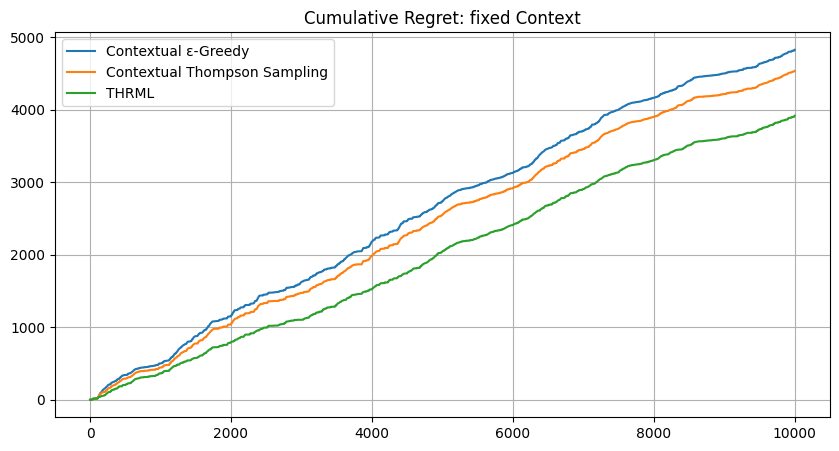

[RUN] Running RANDOM Context (Batched execution to prevent OOM)... 
   - Processing seeds 0 to 50... [242.8s]
   - Processing seeds 50 to 100... [216.4s]
   - Processing seeds 100 to 150... [216.5s]
   - Processing seeds 150 to 200... [216.4s]
   [DONE] Total Context mode completed in 892.1s


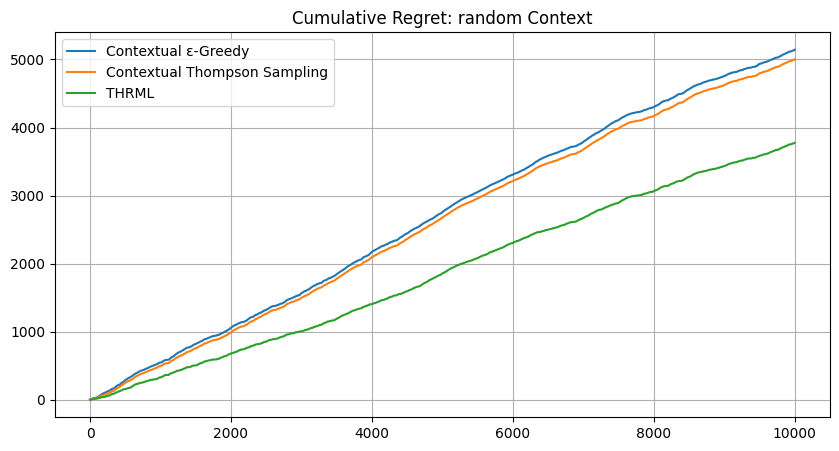

MODE       | Contextual ε-Greedy | Contextual Thompson Sampling | THRML     
fixed      | 4823.86    | 4532.97    | 3914.27   
random     | 5141.93    | 5000.64    | 3775.45   


In [15]:
# Run the experiment
execute_experiment()